# Air Quality Prediction - Eshan Sud

# Step 1: Setting Up Environment and Importing Libraries

## Install Python 3.12+

    "https://www.python.org/downloads/release/python-3130/"

## Installing necessary libraries

    pip install kagglehub
    pip install pandas
    pip install numpy
    pip install matplotlib
    pip install seaborn
    pip install scikit-learn

### Downloading the dataset from Kaggle


In [23]:
# Importing Required Libraries For Downlaoding the Dataset from Kaggle
import kagglehub
import os
import shutil

In [24]:
# Download latest version
source_path = kagglehub.dataset_download("fedesoriano/air-quality-data-set")

# Ensure the dataset is moved to a 'Dataset' folder in the current working directory
destination_folder = os.path.join(os.getcwd(), 'Dataset')
os.makedirs(destination_folder, exist_ok=True)

# Move inner dataset from Source path to the 'Dataset' folder
if os.path.exists(source_path):
    for filename in os.listdir(source_path):
        file_path = os.path.join(source_path, filename)
        if os.path.isfile(file_path):
            shutil.move(file_path, destination_folder)

print("Path to dataset files moved to:", destination_folder)


Path to dataset files moved to: c:\Users\Eshan Sud\Desktop\Air Quality Prediction\Dataset


In [25]:
# Importing Required Libraries For Exploratory Data Analaysis and Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score


In [26]:
# Display plots in the notebook
%matplotlib inline

# Step 2: Loading the Dataset


In [27]:
import pandas as pd

# Load the dataset
df = pd.read_csv("./Dataset/AirQuality.csv", sep=";")
print("Dataset Loaded Successfully!")

# Limit to first 200 rows
df_limited = df.head(200)
print(df_limited)


Dataset Loaded Successfully!
           Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0    10/03/2004  18.00.00    2,6       1360.0     150.0     11,9   
1    10/03/2004  19.00.00      2       1292.0     112.0      9,4   
2    10/03/2004  20.00.00    2,2       1402.0      88.0      9,0   
3    10/03/2004  21.00.00    2,2       1376.0      80.0      9,2   
4    10/03/2004  22.00.00    1,6       1272.0      51.0      6,5   
..          ...       ...    ...          ...       ...      ...   
195  18/03/2004  21.00.00    3,2       1430.0    -200.0     14,1   
196  18/03/2004  22.00.00    2,1       1333.0    -200.0     10,3   
197  18/03/2004  23.00.00    1,7       1262.0    -200.0      8,3   
198  19/03/2004  00.00.00      2       1287.0    -200.0      8,9   
199  19/03/2004  01.00.00    1,6       1134.0    -200.0      6,6   

     PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046.0    166.0        1056.0    113.0        1692.0       12

# Step 3: Data Preparation and Cleaning


In [28]:
# Display basic information
print(df.info())
print(df.describe())

# Check the actual column names
print("Column Names:", df.columns)

# Check missing values
print("Total Missing Values:\n", df.isnull().sum())

# Drop unnecessary columns (adjust column names based on actual data)
# Drop columns like 'Date' and 'Time' if they are not numeric
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col or col in ['Date', 'Time']])

# Replace invalid entries (-200) with NaN
df = df.replace(-200, np.nan)

# Convert columns to numeric (after replacing commas and non-numeric values)
numeric_columns = df.select_dtypes(include=['object']).columns

for col in numeric_columns:
    df[col] = df[col].str.replace(',', '.')
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce any non-numeric values to NaN

# Check for missing values after cleaning
print("Total Missing Values (After Clean-up):\n", df.isnull().sum())

# Impute missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Check for duplicates and drop them
df_imputed.drop_duplicates(inplace=True)
print("Data Duplicates Removed!")

# Display the result
print(df_imputed.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB
None

# Step 4: Feature Engineering


In [29]:
# Feature Engineering: Example - Pollution Index
df_imputed['Pollution_Index'] = df_imputed[['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']].sum(axis=1)
print("Pollution Index Feature Added!")


Pollution Index Feature Added!


# Step 5: Exploratory Data Analysis (EDA)


### Univariate Analysis:

In [30]:
# Summary statistics
df_imputed.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Pollution_Index
count,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000
mean,-33.678011,1094.447393,235.529089,2.536621,936.344543,228.995271,841.846027,109.020638,1438.132654,1018.268115,10.475542,40.281354,-6.195593,306.874520
std,77.208825,219.963544,184.985197,39.773429,268.589264,205.388129,261.600184,47.609517,358.343076,404.519144,41.542633,49.398921,37.411628,274.334974
min,-200.000000,647.000000,7.000000,-200.000000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-200.000000,-200.000000,-200.000000,-297.000000
25%,0.600000,930.000000,97.000000,4.000000,729.000000,88.200000,660.000000,73.000000,1203.000000,719.500000,11.000000,34.200000,0.695900,123.250000
50%,1.500000,1059.000000,175.000000,7.900000,907.000000,160.000000,809.000000,105.000000,1451.000000,958.000000,17.300000,48.600000,0.979100,257.800000
75%,2.600000,1228.000000,323.200000,13.700000,1116.000000,303.000000,980.000000,137.000000,1664.000000,1273.000000,24.100000,61.900000,1.298550,439.150000
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,1808.700000


### Multivariate Analysis:

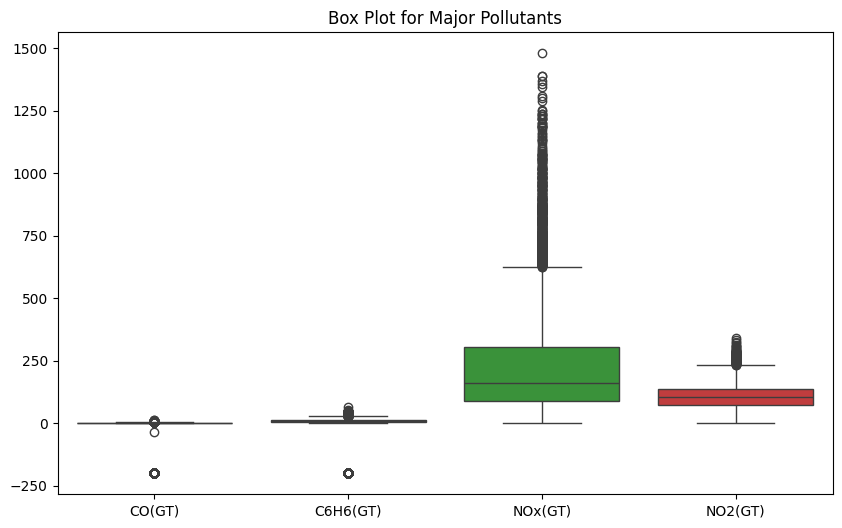

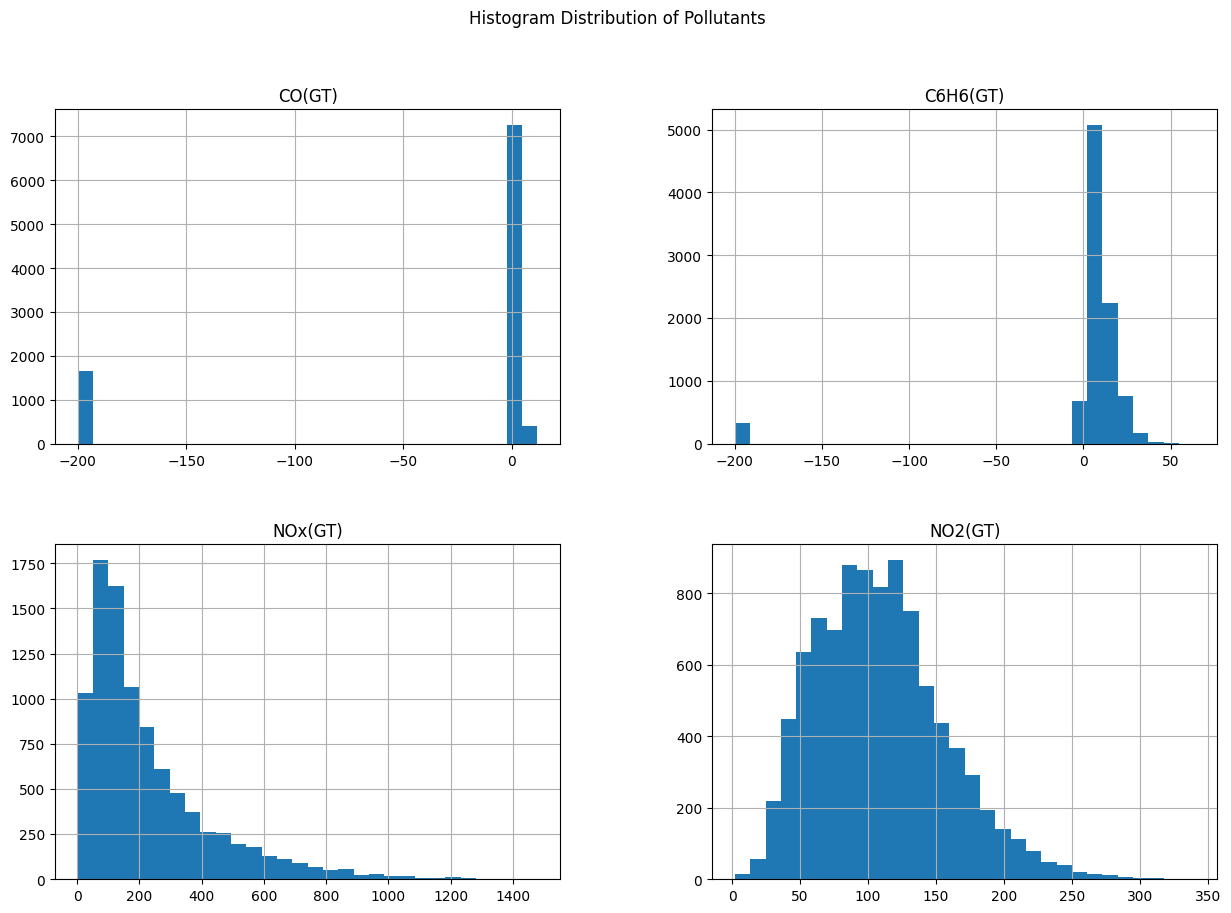

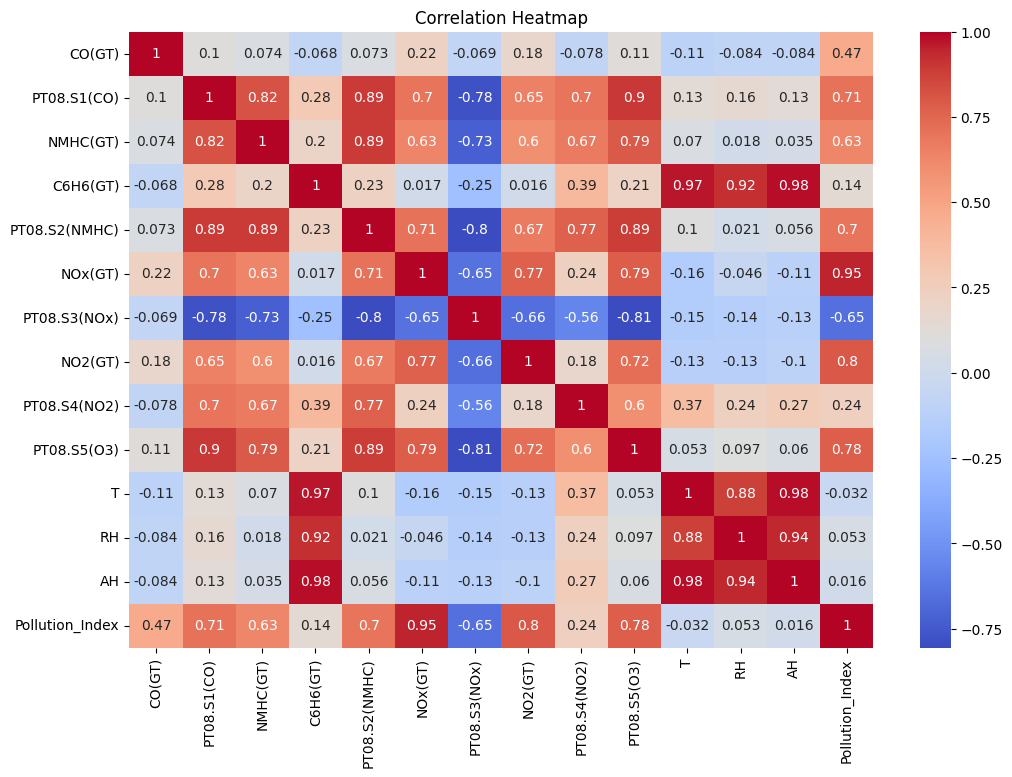

In [31]:
# Box Plot for Outliers in Pollutants
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_imputed[['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']])
plt.title("Box Plot for Major Pollutants")
plt.show()

# Histograms for Air Quality Features
df_imputed[['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogram Distribution of Pollutants")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# Step 6: Predictive Modeling

## Define Features and Target Variable


In [36]:
# Define input features and target variable
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = df_imputed[features]
Y = df_imputed['NO2(GT)']

# Splitting the Data (80/20 Train-Test Split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data Split into Training and Testing Sets Successfully!")


Data Split into Training and Testing Sets Successfully!


## Train and Evaluate Models


In [38]:
# Define models to train
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Function to Train and Evaluate Models
def evaluate_model_cv(model, X_train, y_train, cv_folds=5):
    # Using K-Fold Cross-Validation
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    mean_mse = -mse_scores.mean()
    mean_r2 = r2_scores.mean()
    return mean_mse, mean_r2


## Predicting NO2(GT)


Predicting NO2(GT):
Linear Regression - MSE: 524.19, R2 Score: 0.77


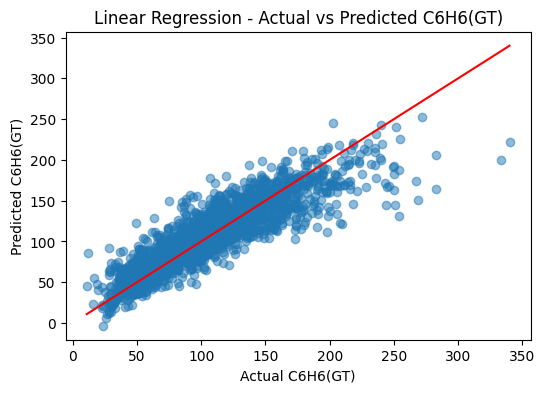

Decision Tree - MSE: 645.40, R2 Score: 0.72


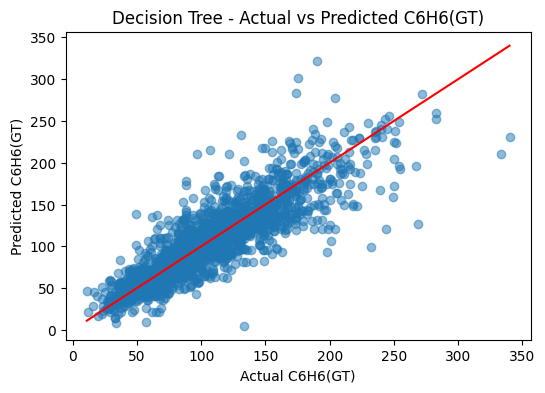

Random Forest - MSE: 326.07, R2 Score: 0.86


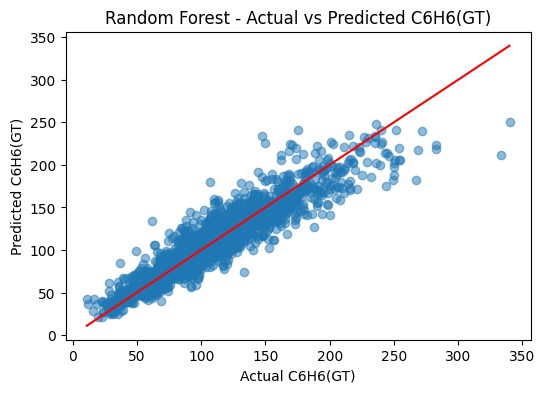

In [39]:
print("Predicting NO2(GT):")
for name, model in models.items():
    mse, r2 = evaluate_model_cv(model, X_train, Y_train)
    print(f"{name} - MSE: {mse:.2f}, R2 Score: {r2:.2f}")
    # Plotting Results on Test Set
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(6, 4))
    plt.scatter(Y_test, y_pred, alpha=0.5)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red')
    plt.title(f"{name} - Actual vs Predicted C6H6(GT)")
    plt.xlabel("Actual C6H6(GT)")
    plt.ylabel("Predicted C6H6(GT)")
    plt.show()

# Step 7: Conclusion


In [35]:
print("Model Evaluation Completed Successfully!")

Model Evaluation Completed Successfully!


### Summary:

#### 1. **Project Overview**
This project aims to predict the concentrations of two major air pollutants:
- **CO(GT)**: Carbon monoxide concentration
- **C6H6(GT)**: Benzene concentration

#### 2. **Dataset Description**
The dataset used includes several attributes:
- **Pollutant Levels**: `CO(GT)`, `C6H6(GT)`, `NOx(GT)`, `NO2(GT)`.
- **Sensor Readings**: `PT08.S1(CO)`, `PT08.S2(NMHC)`, `PT08.S3(NOx)`, `PT08.S4(NO2)`, `PT08.S5(O3)`.
- **Environmental Factors**: Temperature (`T`), Relative Humidity (`RH`), Absolute Humidity (`AH`).

#### 3. **Data Preparation and Cleaning**
- Removed unnecessary columns (`Date`, `Time`).
- Replaced invalid data entries (`-200`) with `NaN`.
- Filled missing values using **KNN Imputer**.
- Dropped duplicate entries to clean the dataset.

#### 4. **Feature Engineering**
- Added a new feature **Pollution Index**, which is the sum of major pollutants (`CO(GT)`, `C6H6(GT)`, `NOx(GT)`, `NO2(GT)`).

#### 5. **Exploratory Data Analysis (EDA)**
- **Summary Statistics**: Provided a detailed statistical overview of the dataset.
- **Box Plots**: Identified outliers in pollutant levels using box plots.
- **Histograms**: Analyzed the distribution of key pollutant features.
- **Correlation Heatmap**: Visualized the correlation between different features to identify relationships.

#### 6. **Predictive Modeling**
- **Features**: Selected sensor readings and environmental factors as predictors (`PT08.S1(CO)`, `PT08.S2(NMHC)`, `PT08.S3(NOx)`, `PT08.S4(NO2)`, `PT08.S5(O3)`, `T`, `RH`, `AH`).
- **Target Variable**:
  - **C6H6(GT)**: Benzene concentration.
- **Train-Test Split**: Split data into training and testing sets (80% train, 20% test).

#### 7. **Models Implemented**
Three regression models were used:
- **Linear Regression**
- **Decision Tree Regressor**
- **Random Forest Regressor**

#### 8. **Model Evaluation Metrics**
- **Mean Squared Error (MSE)**: Evaluates the average squared difference between actual and predicted values.
- **R² Score**: Measures the proportion of variance explained by the model.

#### 9. **Results**
- Plotted **Actual vs. Predicted** values for **C6H6(GT)**.
- Evaluated and compared performance metrics (MSE, R² Score) across different models.
  - **Linear Regression**: MSE: 524.19, R²: 0.77
  - **Decision Tree**: MSE: 645.40, R²: 0.72
  - **Random Forest**: MSE: 326.07, R²: 0.86

#### 10. **Conclusion**
The project successfully performed data cleaning, feature engineering, EDA, and predictive modeling. The implemented models provided insights into **NO2(GT)**, with **Random Forest** yielding the best prediction accuracy with an R² score of 0.86. **Linear Regression** performed reasonably well with an R² score of 0.77, while **Decision Tree** had the lowest performance, with an R² score of 0.72. The results indicate that Random Forest is the most effective model for predicting **NO2(GT)** in this dataset.
